In [22]:
import numpy as np
import scipy.stats as stats
import numba
import matplotlib.pyplot as plt

In [12]:
def cis_overlap(ci1, ci2) -> bool:
    return (ci2.low <= ci1.low <= ci2.high) or (ci1.low <= ci2.low <= ci1.high)

In [35]:
n_samples = 500
n_sets = 100
n_resamples = 10000

## Determining Distribution Equality Using a CI of the Bootstrapped KS Statistic

We sample from two distributions, $A$ and $B$, and attempt to bootstrap a CI on the KS statistic.

Let $X_{A,i}$ be a vector of N samples from distribution A, for $i \in \{1..N_{sets}\}$. "A" is a stand-in for Python simulation code, "B" for the IDL. The "sets" are a stand-in for simulation runs.

Let $K_{j,k}$ be the KS statistic applied to sample vectors j and k.

### Test 1

This is one method that was suggested in our call. I am not entirely sure it is implemented as described. The expectation is that, since sets of samples are from the same distribution, the test would confirm that the distributions are equivalent.

A and B ~ N(0,1)

We bootstrap two 95% confidence intervals: 

$CI_1$ is constructed by sampling from $K_{j,k}, \forall j \in X_{A,i}$, $\forall k \in X_{A,i}$

$CI_2$ is constructed by sampling from $K_{j,k}, \forall j \in X_{B,i}$, $\forall k \in X_{B,i}$

We run this process repeatedly, and find that the CIs overlap in 31% of trials. This does not appear to be successful.

In [ ]:
def bootstrap_ks(first: 

In [56]:
results = []

X_A = [np.random.normal(loc=0.0, scale=1.0, size=n_samples) for x in range(n_sets)]
X_B = [np.random.poisson(size=n_samples) for x in range(n_sets)]
# X_B = [np.random.normal(loc=0.0, scale=1.0, size=n_samples) for x in range(n_sets)]

In [57]:
choices = []
resample_results = []

for x in range(n_resamples):
    # Grab two sets, could be from A or B
    choice1 = int(np.random.rand() * n_sets)
    choice2 = int(np.random.rand() * n_sets)
    choices.append((choice1, choice2))
    
    if choice1 < 50:
        choice1 = X_A[choice1]
    else:
        choice1 = X_B[choice1 - n_sets]
        
    if choice2 < 50:
        choice2 = X_A[choice2]
    else:
        choice2 = X_B[choice2 - n_sets]
    
    # Calculate the KS/AD statistic, add to list
    resample_results.append(stats.kstest(choice1, choice2).statistic)

# Test if the distribution of the statistic is normal (should be, because CLT)
    
# Find the 95% CI on the calculated statistic, using normal if it's normal, otherwise non-parametric approach

# Calculate the significance of the mean KS statistic, use this as the significance test
    
        
        

In [48]:
np.sqrt(-np.log(0.05/2)*.5 * (1 + 1)/(2*n_sets))

0.13581015157406195

In [43]:
np.quantile(resample_results, 0.025)

0.03

In [44]:
np.quantile(resample_results, 0.975)

0.446

In [58]:
np.mean(resample_results)

0.2735286

(array([104.,   0.,   0.,   0.,   0.,  69., 173., 305., 738., 466., 462.,
        715., 422., 364., 387., 180., 143., 192.,  78.,  48.,  56.,  14.,
         25.,  20.,   5.,   9.,  12.,   2.,   0.,   0.,   1.,   0.,   3.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   5.,  20.,
         39.,  75., 124., 236., 228., 318., 284., 204., 436., 300., 371.,
        499., 298., 307., 355., 252., 230., 227.,  89.,  58.,  28.,  11.,
          9.]),
 array([0.    , 0.0047, 0.0094, 0.0141, 0.0188, 0.0235, 0.0282, 0.0329,
        0.0376, 0.0423, 0.047 , 0.0517, 0.0564, 0.0611, 0.0658, 0.0705,
        0.0752, 0.0799, 0.0846, 0.0893, 0.094 , 0.0987, 0.1034, 0.1081,
        0.1128, 0.1175, 0.1222, 0.1269, 0.1316, 0.1363, 0.141 , 0.1457,
        0.1504, 0.1551, 0.1598

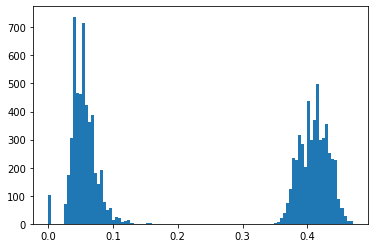

In [46]:
plt.hist(resample_results, bins=100)

In [32]:
stats.anderson(resample_results)

AndersonResult(statistic=1412.6273241475865, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [9]:
results = []

for x in range(n_repetitions):
    X_A = [np.random.normal(loc=0.0, scale=1.0, size=n_samples) for x in range(n_sets)]
    X_B = [np.random.normal(loc=0.0, scale=1.0, size=n_samples) for x in range(n_sets)]

    # Calculate KS statistics for all X_A and X_B, reshape for use in bootstrapping
    KS_A_A = np.expand_dims([stats.kstest(x, y).statistic for x_ind, x in enumerate(X_A) for y_ind, y in enumerate(X_A) if x_ind != y_ind], axis=0)
    KS_B_B = np.expand_dims([stats.kstest(x, y).statistic for x_ind, x in enumerate(X_B) for y_ind, y in enumerate(X_B) if x_ind != y_ind], axis=0)

    # Bootstrap two CIs
    CI_A_A = stats.bootstrap(KS_A_A, np.mean, n_resamples=n_resamples).confidence_interval
    CI_B_B = stats.bootstrap(KS_B_B, np.mean, n_resamples=n_resamples).confidence_interval

    # Test for overlap of the CIs
    results.append(cis_overlap(CI_A_A, CI_B_B))

np.mean(results)

0.53

### Test 2

This is a method that I came up with that seems, to me, to be valid. If it is not, please help me to understand why.

A and B ~ N(0,1)

Let $P_{j,k}$ be the p-values resulting from the KS test $\forall j \in X_{A,i}$, $\forall k \in X_{A,i}$ 

We construct a 95% confidence interval by sampling from $P_{j,k}$

The resulting CI is (0.27, 0.29), suggesting that that the 

In [ ]:
def kstest_pvalue(x, y, axis):
    return stats.kstest(x, y).pvalue

In [ ]:
results = []

X_A = np.random.normal(loc=0.0, scale=1.0, size=n_sets*n_samples)
X_B = np.random.normal(loc=0.0, scale=1.0, size=n_sets*n_samples)

CI_P_A_B = stats.bootstrap((X_A, X_B), np.vectorize(kstest_pvalue, signature="(n),(n),()->()"), paired=True, batch=5, n_resamples=n_resamples).confidence_interval

In [ ]:
CI_P_A_B

In [ ]:
results = []

X_A = np.hstack([np.random.normal(loc=x, scale=1.0, size=n_samples//5) for x in np.random.normal(loc=0.0, scale=0.05, size=n_sets)])
X_B = np.hstack([np.random.normal(loc=x, scale=1.0, size=n_samples//5) for x in np.random.normal(loc=0.0, scale=0.03, size=n_sets)])

CI_P_A_B = stats.bootstrap((X_A, X_B), np.vectorize(kstest_pvalue, signature="(n),(n),()->()"), paired=True, batch=5, n_resamples=n_resamples).confidence_interval
CI_P_A_B

### Test 2: A ~ N(0, 1), B ~ N(1, 1)

We repeat the process from Test 1 and find that the CIs overlap in 35% of trials.


In [ ]:
results = []

for x in range(n_repetitions):
    X_A = [np.random.normal(loc=0.0, scale=1.0, size=n_samples) for x in range(n_sets)]
    X_B = [np.random.normal(loc=1.0, scale=1.0, size=n_samples) for x in range(n_sets)]

    # Calculate KS statistics for all X_A and X_B, reshape for use in bootstrapping
    KS_A_A = np.expand_dims([stats.kstest(x, y).statistic for x in X_A for y in X_A], axis=0)
    KS_B_B = np.expand_dims([stats.kstest(x, y).statistic for x in X_B for y in X_B], axis=0)

    # Bootstrap two CIs
    CI_A_A = stats.bootstrap(KS_A_A, np.mean, n_resamples=n_resamples).confidence_interval
    CI_B_B = stats.bootstrap(KS_B_B, np.mean, n_resamples=n_resamples).confidence_interval

    # Test for overlap of the CIs
    results.append(cis_overlap(CI_A_A, CI_B_B))

np.mean(results)

### Test 3: A ~ N(0, 1), B ~ N(1, 2)

We repeat the process from Test 1 and find that the CIs overlap in 25% of trials.

In [ ]:
results = []

for x in range(n_repetitions):
    X_A = [np.random.normal(loc=0.0, scale=1.0, size=n_samples) for x in range(n_sets)]
    X_B = [np.random.normal(loc=1.0, scale=2.0, size=n_samples) for x in range(n_sets)]

    # Calculate KS statistics for all X_A and X_B, reshape for use in bootstrapping
    KS_A_A = np.expand_dims([stats.kstest(x, y).statistic for x in X_A for y in X_A], axis=0)
    KS_B_B = np.expand_dims([stats.kstest(x, y).statistic for x in X_B for y in X_B], axis=0)

    # Bootstrap two CIs
    CI_A_A = stats.bootstrap(KS_A_A, np.mean, n_resamples=n_resamples).confidence_interval
    CI_B_B = stats.bootstrap(KS_B_B, np.mean, n_resamples=n_resamples).confidence_interval

    # Test for overlap of the CIs
    results.append(cis_overlap(CI_A_A, CI_B_B))

np.mean(results)

## Cross-joined pairs


### Comparing cross-joined to within set 1

In [ ]:
results = []

for x in range(n_repetitions):
    X_A = [np.random.normal(loc=0.0, scale=1.0, size=n_samples) for x in range(n_sets)]
    X_B = [np.random.normal(loc=0.0, scale=1.0, size=n_samples) for x in range(n_sets)]

    # Calculate KS statistics for all X_A and X_B, reshape for use in bootstrapping
    KS_A_B = np.expand_dims([stats.kstest(x, y).statistic for x in X_A for y in X_B], axis=0)
    KS_B_B = np.expand_dims([stats.kstest(x, y).statistic for x in X_B for y in X_B], axis=0)

    # Bootstrap two CIs
    CI_A_B = stats.bootstrap(KS_A_B, np.mean, n_resamples=n_resamples).confidence_interval
    CI_B_B = stats.bootstrap(KS_B_B, np.mean, n_resamples=n_resamples).confidence_interval

    # Test for overlap of the CIs
    results.append(cis_overlap(CI_A_B, CI_B_B))

np.mean(results)

In [ ]:
results = []

for x in range(n_repetitions):
    X_A = [np.random.normal(loc=0.0, scale=1.0, size=n_samples) for x in range(n_sets)]
    X_B = [np.random.normal(loc=1.0, scale=1.0, size=n_samples) for x in range(n_sets)]

    # Calculate KS statistics for all X_A and X_B, reshape for use in bootstrapping
    KS_A_B = np.expand_dims([stats.kstest(x, y).statistic for x in X_A for y in X_B], axis=0)
    KS_B_B = np.expand_dims([stats.kstest(x, y).statistic for x in X_B for y in X_B], axis=0)

    # Bootstrap two CIs
    CI_A_B = stats.bootstrap(KS_A_B, np.mean, n_resamples=n_resamples).confidence_interval
    CI_B_B = stats.bootstrap(KS_B_B, np.mean, n_resamples=n_resamples).confidence_interval

    # Test for overlap of the CIs
    results.append(cis_overlap(CI_A_B, CI_B_B))

np.mean(results)

In [ ]:
results = []

for x in range(n_repetitions):
    X_A = [np.random.normal(loc=0.0, scale=1.0, size=n_samples) for x in range(n_sets)]
    X_B = [np.random.normal(loc=1.0, scale=1.0, size=n_samples) for x in range(n_sets)]

    # Calculate KS statistics for all X_A and X_B, reshape for use in bootstrapping
    KS_A_B = np.expand_dims([stats.kstest(x, y).statistic for x in X_A for y in X_B], axis=0)
    KS_B_B = np.expand_dims([stats.kstest(x, y).statistic for x in X_B for y in X_B], axis=0)

    # Bootstrap two CIs
    CI_A_B = stats.bootstrap(KS_A_B, np.mean, n_resamples=n_resamples).confidence_interval
    CI_B_B = stats.bootstrap(KS_B_B, np.mean, n_resamples=n_resamples).confidence_interval

    # Test for overlap of the CIs
    results.append(cis_overlap(CI_A_B, CI_B_B))
    if x % 5 == 0:
        print(np.mean(results))

np.mean(results)

In [ ]:
n_samples = 500
n_sets = 50

set1 = [np.random.normal(scale=1.0, size=n_samples) for x in range(n_sets)]
set2 = [np.random.normal(scale=1.0, size=n_samples) for x in range(n_sets)]

all_pairs_ks_set1 = [stats.kstest(x, y).statistic for x in set1 for y in set2]
all_pairs_ks_set2 = [stats.kstest(x, y).statistic for x in set1 for y in set1]

ci_set1 = stats.bootstrap(np.array(all_pairs_ks_set1).reshape((1, len(all_pairs_ks_set1))), np.mean, n_resamples=10000)
ci_set2 = stats.bootstrap(np.array(all_pairs_ks_set2).reshape((1, len(all_pairs_ks_set2))), np.mean, n_resamples=10000)

cis_overlap(ci_set1.confidence_interval, ci_set2.confidence_interval)

### Comparing unequal means

In [ ]:
n_samples = 500
n_sets = 50

set1 = [np.random.normal(scale=1.0, size=n_samples) + 1 for x in range(n_sets)]
set2 = [np.random.normal(scale=1.0, size=n_samples) for x in range(n_sets)]

all_pairs_ks_set1 = [stats.kstest(x, y).statistic for x in set1 for y in set2]
all_pairs_ks_set2 = [stats.kstest(x, y).statistic for x in set1 for y in set1]

ci_set1 = stats.bootstrap(np.array(all_pairs_ks_set1).reshape((1, len(all_pairs_ks_set1))), np.mean, n_resamples=10000)
ci_set2 = stats.bootstrap(np.array(all_pairs_ks_set2).reshape((1, len(all_pairs_ks_set2))), np.mean, n_resamples=10000)

cis_overlap(ci_set1.confidence_interval, ci_set2.confidence_interval)

### Comparing unequal variances

In [ ]:
n_samples = 500
n_sets = 50

set1 = [np.random.normal(scale=1.5, size=n_samples) for x in range(n_sets)]
set2 = [np.random.normal(scale=1.0, size=n_samples) for x in range(n_sets)]

all_pairs_ks_set1 = [stats.kstest(x, y).statistic for x in set1 for y in set2]
all_pairs_ks_set2 = [stats.kstest(x, y).statistic for x in set1 for y in set1]

ci_set1 = stats.bootstrap(np.array(all_pairs_ks_set1).reshape((1, len(all_pairs_ks_set1))), np.mean, n_resamples=10000)
ci_set2 = stats.bootstrap(np.array(all_pairs_ks_set2).reshape((1, len(all_pairs_ks_set2))), np.mean, n_resamples=10000)

cis_overlap(ci_set1.confidence_interval, ci_set2.confidence_interval)

In [ ]:
filtered = parsed_df[((parsed_df.fully_successful == 1) | (parsed_df.partially_successful == 1))]
parsed_df["document_text"] = filtered.pagewise_text.str.join("\n")